In [ ]:
# !pip install cloud-tpu-client==0.10 torch==1.11.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl

In [ ]:
%matplotlib inline
import torchvision.models as models
from matplotlib import pyplot as plt
import os
import numpy as np
import collections
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchsummary import summary
import random
# import torch_xla
# import torch_xla.core.xla_model as xm
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

In [ ]:
# device = xm.xla_device()
device = torch.device('cuda')

device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/MyDrive/ASL_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2863).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2864).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2865).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2866).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2867).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2868).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2869).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (287).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2870).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2871).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2872).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2873).jpg  
  inflating: A

In [ ]:
import torch
model = models.resnet18(pretrained=False)

In [ ]:
preprocess = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.5404, 0.5179, 0.5214],
            std=[0.1834, 0.2156, 0.2281])
])

In [ ]:
file_path = '/content/ASL_Alphabet_Dataset/asl_alphabet_train'
# file_path_total = ['/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/A',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/B',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/C',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/D',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/E',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/F',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/G',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/H',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/I',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/J',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/K',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/L',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/M',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/N',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/O',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/P',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/Q',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/R',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/S',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/T',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/U',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/V',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/W',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/X',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/Y',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/Z',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/del',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/nothing',
#                '/content/drive/MyDrive/ASL_Dataset/asl_alphabet_train/space',
# ]

In [ ]:
# from pathlib import Path
# import random

# def delete_images(directory, number_of_images, extension='jpg'):
#     images = Path(directory).glob(f'*.{extension}')
#     for image in random.sample(list(images), number_of_images):
#         image.unlink()

# for i in list(file_path_total): 
#   dir=list(os.listdir(i))
#   length = len(dir)
#   delete_images(i, int(length/2))


In [ ]:
dataset = ImageFolder(file_path, transform=preprocess)
print(len(datset))
def train_val_dataset(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    training_set = Subset(dataset, train_idx)
    val_set = Subset(dataset, val_idx)
    return training_set,val_set

In [ ]:
def test(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
      for imgs, labels in test_loader:
          imgs, labels = imgs.to(device), labels.to(device)
          batch_size = imgs.shape[0]
          outputs = model(imgs)
          _, predicted = torch.max(outputs, dim=1)
          total += labels.shape[0]
          correct += int((predicted == labels).sum())
    print("Accuracy: {:.2f}".format(correct / total))

In [ ]:
train_set,val_set = train_val_dataset(dataset)
print(len(train_set))
print(len(val_set))

178459
44615


In [ ]:
import datetime
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, validation_loader):
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    loss_val = 0.0
    for imgs, labels in train_loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      outputs = model(imgs)
      loss = loss_fn(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_train += loss.item()
    # with torch.no_grad():
    #   for val_imgs,val_labels in validation_loader:
    #     val_imgs = val_imgs.to(device=device); val_labels = val_labels.to(device=device)
    #     val_outputs = model(val_imgs)
    #     val_loss = loss_fn(val_outputs,val_labels)
    #     loss_val += val_loss.item()
    print('{} Epoch {}, Training loss {}'.format(
    datetime.datetime.now(), epoch,
    loss_train / len(train_loader)))
    # print('{} Epoch {}, Validation loss {}'.format(
    # datetime.datetime.now(), epoch,
    # loss_val / len(validation_loader)))

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256,
                                          shuffle=True)
validation_loader = torch.utils.data.DataLoader(val_set, batch_size=256,
                                          shuffle=True)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
model = model.to(device=device)

training_loop(
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    validation_loader = validation_loader
)

2022-05-11 16:18:49.805970 Epoch 1, Training loss 1.5200335089661672
2022-05-11 16:26:48.322683 Epoch 2, Training loss 0.4286527425306916
2022-05-11 16:34:08.811497 Epoch 3, Training loss 0.17115929096211335
2022-05-11 16:41:21.098896 Epoch 4, Training loss 0.083684160867786
2022-05-11 16:48:33.110258 Epoch 5, Training loss 0.04952981108986375
2022-05-11 16:55:45.986836 Epoch 6, Training loss 0.04324302453424963
2022-05-11 17:02:57.613232 Epoch 7, Training loss 0.020308534987003978
2022-05-11 17:10:07.830250 Epoch 8, Training loss 0.014686124696847276
2022-05-11 17:17:20.570175 Epoch 9, Training loss 0.011776296164370795
2022-05-11 17:24:30.825988 Epoch 10, Training loss 0.012039902955587196


In [ ]:
rmdir /content/ASL_Alphabet_Dataset/Personal_test/.ipynb_checkpoints

In [ ]:
torch.save(model, 'Trained_Model_ResNet_18_RT')

In [ ]:
model1 = torch.load('Trained_Model_ResNet_18_RT')
model1.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([]) 
    for images, labels in loader:
        images, labels = images.to(device=device),labels.to(device=device)

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [ ]:
validation_loader = torch.utils.data.DataLoader(val_set, batch_size=256,
                                          shuffle=False)
test(model = model1, test_loader = validation_loader)

Accuracy: 0.99


In [ ]:
with torch.no_grad():
    train_preds = get_all_preds(model, validation_loader)

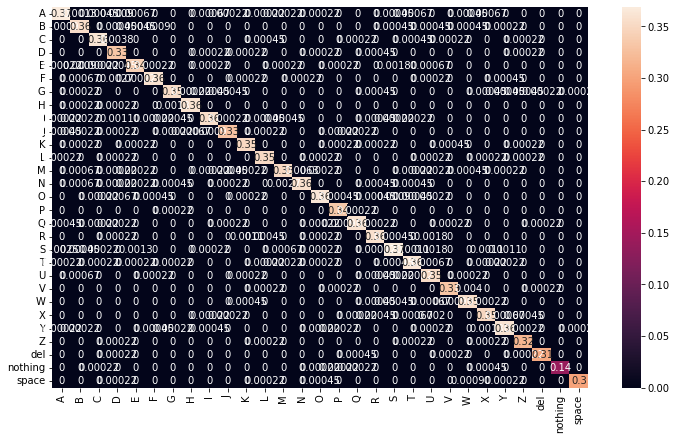

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in validation_loader:
        inputs=inputs.to(device); labels=labels.to(device)
        output = model1(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).cpu().detach().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().detach().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P',
           'Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space')


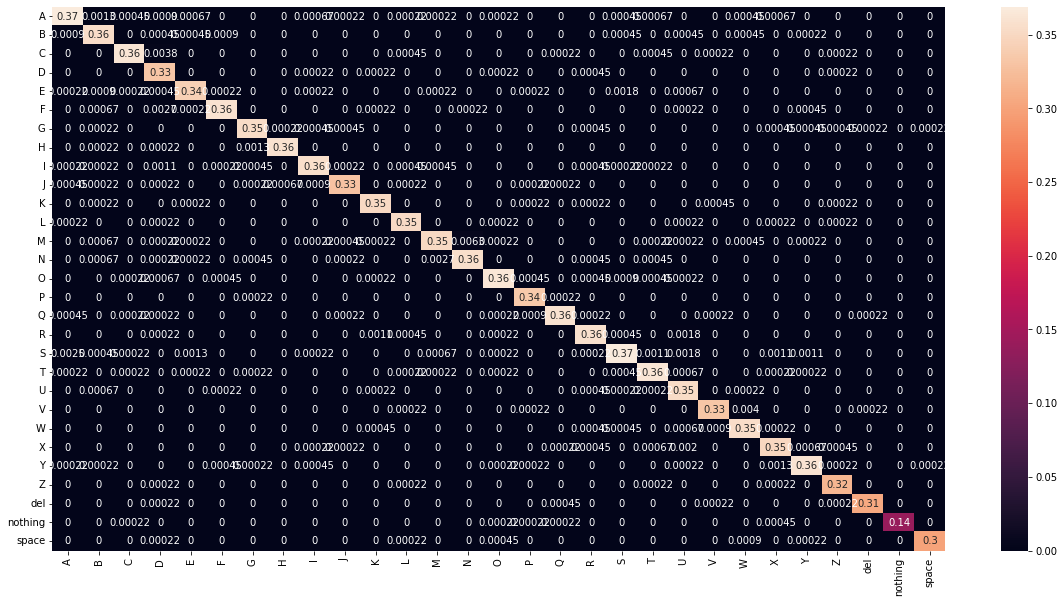

In [ ]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
plt.savefig('CnfMatrix_ResNet18_1.png')

In [ ]:
# import seaborn as sns
# ax = sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues')

# ax.set_title('ASL Validation Confusion Matrix\n\n');
# ax.set_xlabel('\nPredicted Values')
# ax.set_ylabel('Actual Values ');

# ## Ticket labels - List must be in alphabetical order
# ax.xaxis.set_ticklabels(['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P',
#            'Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space'])
# ax.yaxis.set_ticklabels(['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P',
#            'Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space'])

# ## Display the visualization of the Confusion Matrix.
# plt.show()
# plt.savefig('CnfMatrix_ResNet18_2.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


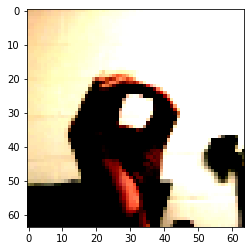

In [ ]:
test_data_dir = '/content/ASL_Alphabet_Dataset/Personal_test'
testset = ImageFolder(test_data_dir, transform=preprocess)
img, label = testset[1]
plt.imshow(img.permute(1, 2, 0))

In [ ]:
test_loader1 = torch.utils.data.DataLoader(testset, batch_size=256,
                                          shuffle=False)

In [ ]:
# To get all labels in dataset, do dataset.targets
dataset.class_to_idx

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'del': 26,
 'nothing': 27,
 'space': 28}

In [ ]:
for img, label in test_loader1:
  img, label = img.to(device), label.to(device)
  outputs2 = model(img)
  _, pred = torch.max(outputs2,dim=1)
  print(pred)

tensor([13, 14,  6,  5], device='cuda:0')
